In [29]:
from ps3.data._sample_split import create_sample_split
from ps3.data._load_transform import load_transform

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import scipy.stats
from dask_ml.preprocessing import Categorizer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ShuffleSplit
from glum import GeneralizedLinearRegressor
from glum import TweedieDistribution




In [14]:
data = load_transform()
data.head()
print(data.head())  # 查看数据前几行
print(data.columns) 

   IDpol  ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus  \
0      1        0      0.10    D         5       0        5          50   
1      3        0      0.77    D         5       0        5          50   
2      5        0      0.75    B         6       1        5          50   
3     10        0      0.09    B         7       0        4          50   
4     11        0      0.84    B         7       0        4          50   

  VehBrand   VehGas  Density Region  ClaimAmount  ClaimAmountCut  
0      B12  Regular     1217    R82          0.0             0.0  
1      B12  Regular     1217    R82          0.0             0.0  
2      B12   Diesel       54    R22          0.0             0.0  
3      B12   Diesel       76    R72          0.0             0.0  
4      B12   Diesel       76    R72          0.0             0.0  
Index(['IDpol', 'ClaimNb', 'Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region', 'Cl

In [23]:
df = create_sample_split(data,id_column='IDpol',training_frac=0.8)
print(df.head())
print(df['sample'].describe())

     IDpol  ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus  \
0  4083105        0      0.36    D         7       1        5          50   
1    79042        0      1.00    E         4       1        2          54   
2  3100375        0      0.52    A         6       1        3          76   
3  2266953        0      0.91    A         9       2        2          63   
4  4027046        0      0.45    D         8       1        3          60   

  VehBrand   VehGas  Density Region  ClaimAmount  ClaimAmountCut  \
0       B4   Diesel      507    R93          0.0             0.0   
1       B2  Regular     3688    R82          0.0             0.0   
2       B1  Regular       37    R24          0.0             0.0   
3       B1  Regular       41    R73          0.0             0.0   
4      B12   Diesel      568    R52          0.0             0.0   

                                 hash sample  
0  1113169414175027208547233381338902  train  
1  1697534723952054286348862868737

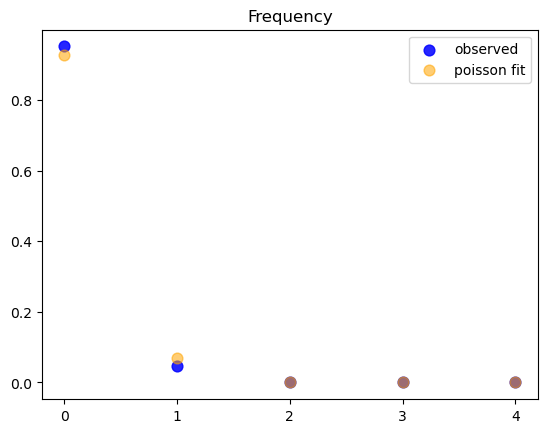

In [31]:
# plt.subplots(figsize=(10, 7))
df_plot = (
    df.loc[:, ['ClaimNb', 'Exposure']].groupby('ClaimNb').sum()
    .assign(Frequency_Observed = lambda x: x.Exposure / df['Exposure'].sum())
)
mean = df['ClaimNb'].sum() / df['Exposure'].sum()

x = range(5)
plt.scatter(x, df_plot['Frequency_Observed'].values, color="blue", alpha=0.85, s=60, label='observed')
plt.scatter(x, scipy.stats.poisson.pmf(x, mean), color="orange", alpha=0.55, s=60, label="poisson fit")
plt.xticks(x)
plt.legend()
plt.title("Frequency")

In [32]:
z = df['ClaimNb'].values
weight = df['Exposure'].values
y = z / weight # claims frequency

ss = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train, test = next(ss.split(y))

categoricals = ["VehBrand", "VehGas", "Region", "Area", "DrivAge", "VehAge", "VehPower"]
predictors = categoricals + ["BonusMalus", "Density"]
glm_categorizer = Categorizer(columns=categoricals)

X_train_p = glm_categorizer.fit_transform(df[predictors].iloc[train])
X_test_p = glm_categorizer.transform(df[predictors].iloc[test])
y_train_p, y_test_p = y[train], y[test]
w_train_p, w_test_p = weight[train], weight[test]
z_train_p, z_test_p = z[train], z[test]

In [33]:
f_glm1 = GeneralizedLinearRegressor(family='poisson', alpha_search=True, l1_ratio=1, fit_intercept=True)

f_glm1.fit(
    X_train_p,
    y_train_p,
    sample_weight=w_train_p
);

pd.DataFrame({'coefficient': np.concatenate(([f_glm1.intercept_], f_glm1.coef_))},
             index=['intercept'] + f_glm1.feature_names_).T

,intercept,VehBrand[B1],VehBrand[B10],VehBrand[B11],VehBrand[B12],VehBrand[B13],VehBrand[B14],VehBrand[B2],VehBrand[B3],VehBrand[B4],...,VehAge[1],VehAge[2],VehPower[4],VehPower[5],VehPower[6],VehPower[7],VehPower[8],VehPower[9],BonusMalus,Density
coefficient,-4.216207,-0.028873,-0.027495,0.161945,-0.277168,0.0,-0.127876,-0.018912,0.027401,0.000459,...,0.024235,-0.157875,-0.075953,-0.019719,0.0,-0.003121,0.025261,0.152618,0.02665,0.000003


4. Combined GLM - Tweedie distribution

In [34]:
weight = df['Exposure'].values
df["PurePremium"] = df["ClaimAmountCut"] / df["Exposure"]
y = df["PurePremium"]

X_train_t = glm_categorizer.fit_transform(df[predictors].iloc[train])
X_test_t = glm_categorizer.transform(df[predictors].iloc[test])
y_train_t, y_test_t = y.iloc[train], y.iloc[test]
w_train_t, w_test_t = weight[train], weight[test]

In [ ]:
TweedieDist = TweedieDistribution(1.5)
t_glm1 = GeneralizedLinearRegressor(family=TweedieDist, alpha_search=True, l1_ratio=1, fit_intercept=True)
t_glm1.fit(X_train_t, y_train_t, sample_weight=w_train_t)


pd.DataFrame({'coefficient': np.concatenate(([t_glm1.intercept_], t_glm1.coef_))},
             index=['intercept'] + t_glm1.feature_names_).T

In [35]:
print('training loss s_glm1: {}'.format(
    TweedieDist.deviance(y_train_t, t_glm1.predict(X_train_t), sample_weight=w_train_t)/np.sum(w_train_t)))

print('testing loss s_glm1:  {}'.format(
    TweedieDist.deviance(y_test_t, t_glm1.predict(X_test_t), sample_weight=w_test_t)/np.sum(w_test_t)))

NameError: name 'TweedieDist' is not defined

In [ ]:
#Put together freq * sev together
print("Total claim amount on train set, observed = {}, predicted = {}".
     format(df['ClaimAmountCut'].values[train].sum(),
            np.sum(df['Exposure'].values[train] * t_glm1.predict(X_train_p)))
     )

print("Total claim amount on test set, observed = {}, predicted = {}".
     format(df['ClaimAmountCut'].values[test].sum(),
            np.sum(df['Exposure'].values[test] * t_glm1.predict(X_test_p)))
     )